In [1]:
lang = "fr"
lang_data = "Fr_data"

import json
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Chargement des données

In [3]:
import os

with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +".train.json", "r") as file_handler:
    dataset = json.load(file_handler)

In [4]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +".dev.json", "r") as file_handler:
    dataset_dev = json.load(file_handler)

In [5]:
sgns = [i['sgns'] for i in dataset]
glosses = [i['gloss'] for i in dataset]

In [6]:
sgns_dev = [i['sgns'] for i in dataset_dev]
glosses_dev = [i['gloss'] for i in dataset_dev]

In [7]:
print(len(glosses_dev))

6375


In [8]:
# Import DATA
with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_lemm2Idx_train.json") as outfile:
    lemm2Idx = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_idx2Lemm_train.json") as outfile:
    idx2Lemm = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_lemmatized_glosses_train.json") as outfile:
    lemmatized_glosses = json.load(outfile)

In [9]:
# Import DATA
with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_lemm2Idx_dev.json") as outfile:
    lemm2Idx_dev = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_idx2Lemm_dev.json") as outfile:
    idx2Lemm_dev = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_lemmatized_glosses_dev.json") as outfile:
    lemmatized_glosses_dev = json.load(outfile)

In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Préparation des données

In [11]:
print(dataset[85]['gloss'])
print(dataset[253]['gloss'])

D'une couleur gris-vert .
( Antiquité ) ( Religion ) Membre de la classe sacerdotale chez les Celtes de Gaule , de Bretagne et d'Irlande .


In [12]:
lemmatized_glosses_text = []

for gloss in lemmatized_glosses:
    text = ""
    for word in gloss:
      try:
        text += idx2Lemm[str(word)] + " "
      except:
        print("An exception occurred : " + str(len(lemmatized_glosses_text)))
        
    lemmatized_glosses_text.append(text)

In [13]:
print(len(lemmatized_glosses_text))
print(len(sgns))


43608
43608


In [14]:
lemmatized_glosses_text_dev = []

for gloss in lemmatized_glosses_dev:
    text = ""
    for word in gloss:
        text += idx2Lemm_dev[str(word)] + " "
    lemmatized_glosses_text_dev.append(text)

In [15]:
print(len(lemmatized_glosses_text_dev))
print(len(sgns_dev))

6375
6375


In [16]:
def longest_gloss(glosses_list):
    lgt = 0
    sentence = ""
    tk = []
    for g in glosses_list :
        tokens = g.split()
        if len(tokens)>lgt :
            lgt = len(tokens)
            sentence =g
            tk = tokens
    return lgt

In [17]:
max_len = longest_gloss(lemmatized_glosses_text)
print(max_len)

149


In [18]:
max_len_dev = longest_gloss(lemmatized_glosses_text_dev)
print(max_len_dev)

111


In [19]:
max_tokens = len(list(lemm2Idx))
print(max_tokens)

max_tokens_dev = len(lemm2Idx_dev)

vectorize_layer = TextVectorization(
    # Max vocab size. Any words outside of the max_tokens most common ones
    # will be treated the same way: as "out of vocabulary" (OOV) tokens.
    max_tokens=max_tokens,
    # Output integer indices, one per string token
    output_mode="int",
    # Always pad or truncate to exactly this many tokens
    output_sequence_length=max_len
)

24089


In [20]:
# Call adapt(), which fits the TextVectorization layer to our text dataset.
# This is when the max_tokens most common words (i.e. the vocabulary) are selected.
vectorize_layer.adapt(np.array(list(idx2Lemm.values())))

In [21]:
print(np.array(list(idx2Lemm.values()))[10])

grand


### Construction du modèle

In [22]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 8.1 MB/s 


In [23]:
import tensorflow_addons as tfa
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-0, 1e-1, 1e-2])
# lr and wd can be a function or a tensor

lr = 1e-1 * schedule(step)

learning_rate=1e-3

wd = lambda: 1e-4 * schedule(step)

weight_decay=1e-6,

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

In [24]:
import torch.optim as optim

opt = keras.optimizers.Adam(learning_rate=0.01)

In [25]:
model = Sequential()
model.add(Input(shape=(1,), dtype="string"))

In [26]:
model.add(vectorize_layer)

In [27]:
from tensorflow.keras import layers
# Note that we're using max_tokens + 1 here, since there's an
# out-of-vocabulary (OOV) token that gets added to the vocab.

len_gloses = 43608

model.add(Embedding(max_tokens + 1, 128))

model.add(Dense(128))

model.add(Bidirectional(LSTM(units=192, return_sequences=True), merge_mode = 'ave'))

model.add(Dense(192))

model.add(LSTM(units=256, return_sequences=False, activation = "softmax"))


model.add(Dense(256))

In [28]:
 model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 149)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 149, 128)          3083520   
                                                                 
 dense (Dense)               (None, 149, 128)          16512     
                                                                 
 bidirectional (Bidirectiona  (None, 149, 192)         493056    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 149, 192)          37056     
                                                                 
 lstm_1 (LSTM)               (None, 256)               4

### Entraînement du modèle

In [29]:
with tf.device('/device:GPU:0'):
  history = model.fit(lemmatized_glosses_text, sgns,
                    epochs=10,
                    batch_size=192,
                    validation_data=(lemmatized_glosses_text_dev,  sgns_dev))

Epoch 1/10
228/228 [==============================] - 91s 368ms/step - loss: 1.0888 - accuracy: 0.0125 - val_loss: 1.0201 - val_accuracy: 0.0121
Epoch 2/10
228/228 [==============================] - 73s 320ms/step - loss: 1.0707 - accuracy: 0.0169 - val_loss: 1.0190 - val_accuracy: 0.0121
Epoch 3/10
228/228 [==============================] - 74s 323ms/step - loss: 1.0704 - accuracy: 0.0169 - val_loss: 1.0190 - val_accuracy: 0.0121
Epoch 4/10
228/228 [==============================] - 73s 320ms/step - loss: 1.0704 - accuracy: 0.0169 - val_loss: 1.0189 - val_accuracy: 0.0121
Epoch 5/10
228/228 [==============================] - 73s 320ms/step - loss: 1.0704 - accuracy: 0.0169 - val_loss: 1.0190 - val_accuracy: 0.0121
Epoch 6/10
228/228 [==============================] - 74s 324ms/step - loss: 1.0704 - accuracy: 0.0169 - val_loss: 1.0190 - val_accuracy: 0.0121
Epoch 7/10
228/228 [==============================] - 73s 322ms/step - loss: 1.0704 - accuracy: 0.0169 - val_loss: 1.0191 - val_ac

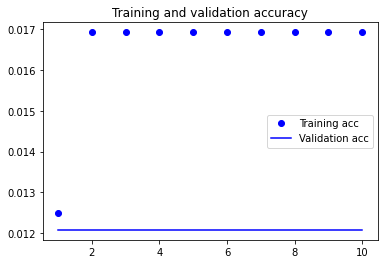

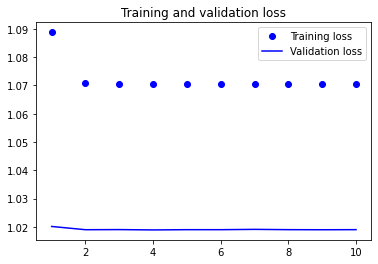

In [30]:
#Visualisation des résultats de l'entraînement.
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
#sauvegarde du modèle
model.save('_fr_revdict_model.tf')

INFO:tensorflow:Assets written to: _fr_revdict_model.tf/assets


INFO:tensorflow:Assets written to: _fr_revdict_model.tf/assets



### Test du modèle sur les données Trial

In [32]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +".trial.complete.json", "r") as file_handler:
    dataset_trial = json.load(file_handler)

In [33]:
glosses_trial = []
for e in dataset_trial :
    glosses_trial.append(e["gloss"])

In [34]:
sgns_trial = []
for e in dataset_trial :
    sgns_trial.append(e["sgns"])

In [35]:
scores = model.evaluate(glosses_trial, sgns_trial, verbose=2)

7/7 - 0s - loss: 1.6444 - accuracy: 0.0250 - 284ms/epoch - 41ms/step


In [36]:
classes_trial = model.predict(glosses_trial, batch_size=32)

In [37]:
print(len(classes_trial))

200


In [38]:
print(len(classes_trial[0]))

256


In [39]:
results = []

prefix_id = "fr.revdict."
i = 0
for g in glosses_trial :
  sample = {}
  id = prefix_id + str(i)
  sample["id"] = id
  sample["gloss"] = g
  sample["sgns"] = classes_trial[glosses_trial.index(g)]
  results.append(sample)
  i+=1

print("taille du resultat : ", len(results))
# affichage du premier vecteur pour visualiser les résultats produits
print("vecteur trial ---> prédiction")
for v in sgns_trial[0] :
  print(v, " ---> ", results[0]["sgns"][list(sgns_trial[0]).index(v)])

taille du resultat :  200
vecteur trial ---> prédiction
-2.372004509  --->  -0.0511041
1.9591083527  --->  0.45062
0.2271074802  --->  -0.38477474
1.099986434  --->  -0.16360968
1.7186322212  --->  0.013098855
-0.1170716509  --->  -0.07511786
-1.3146365881  --->  -0.14198709
-0.6552742124  --->  0.0009245416
-1.9913749695  --->  0.036763232
-3.2809066772  --->  -0.17469871
0.2689187229  --->  0.06842947
-1.5716910362  --->  0.044439193
-1.6752529144  --->  -0.052377813
-0.9022228718  --->  -0.31669855
-0.1585022509  --->  -0.10088621
-2.2514564991  --->  -0.25310344
2.0232255459  --->  -0.0723949
0.3152128756  --->  -0.013035178
-0.5735642314  --->  0.12590769
3.8056907654  --->  0.08885661
1.185995698  --->  0.16749646
0.8157326579  --->  -0.47296047
3.2507917881  --->  -0.16693643
-1.4944301844  --->  0.15481846
-1.6375355721  --->  -0.2901123
2.044917345  --->  -0.19605866
-4.9128074646  --->  -0.0171621
0.0966427699  --->  0.23307446
0.0779954046  --->  0.4172031
-1.5106123686  ---

In [40]:
import pandas as pd
pd.Series(results).to_json("/content/drive/My Drive/Datasets/Data_semEval2022/Results/sgns/"+lang+"_revdict_results_prediction_trial.json", orient='values')

### Calcule des métriques d'évaluation

In [41]:
import torch.nn.functional as F
import torch

classes_trial_tensor = torch.tensor(classes_trial)
sgns_trial_tensor = torch.tensor(sgns_trial)

In [42]:
cos_sim = F.cosine_similarity(classes_trial_tensor, sgns_trial_tensor).mean().item()

In [43]:
print(cos_sim)

0.27848565578460693


In [44]:
mse = F.mse_loss(classes_trial_tensor, sgns_trial_tensor).item()

In [45]:
print(mse)

1.6444123983383179


In [46]:
# fonction prise du code de la baseline.
def rank_cosine(preds, targets):
    unique_targets = targets.unique(dim=0)
    all_assocs = preds @ F.normalize(targets).T
    unique_assocs = preds @ F.normalize(unique_targets).T
    refs = torch.diagonal(all_assocs, 0).unsqueeze(1)
    ranks = (unique_assocs >= refs).sum(1).float().mean().item()
    return ranks / unique_targets.size(0)

In [47]:
rnk = rank_cosine(classes_trial_tensor, sgns_trial_tensor)

In [48]:
print(rnk)

0.5005778787124097


### Test du modèle sur les données de DEV


In [49]:
scores = model.evaluate(glosses_dev, sgns_dev, verbose=2)

200/200 - 6s - loss: 1.0190 - accuracy: 0.0121 - 6s/epoch - 32ms/step


In [50]:
classes_dev = model.predict(glosses_dev, batch_size=32)

In [51]:
print(len(classes_dev))

6375


In [52]:
print(len(classes_dev[0]))

256


In [53]:
results_dev = []

prefix_id = "fr.revdict."
i = 0
for g in glosses_dev :
  sample = {}
  id = prefix_id + str(i)
  sample["id"] = id
  sample["gloss"] = g
  sample["sgns"] = classes_dev[glosses_dev.index(g)]
  results_dev.append(sample)
  i+=1

print("taille du résultat : ", len(results_dev))
print("vecteur dev ---> prédiction")
for v in sgns_dev[0] :
  print(v, " ---> ", results_dev[0]["sgns"][list(sgns_dev[0]).index(v)])

taille du résultat :  6375
vecteur dev ---> prédiction
-0.5418303013  --->  -0.0511041
0.5813987851  --->  0.45062
-2.0320107937  --->  -0.38477474
-0.353790462  --->  -0.16360968
-1.0130099058  --->  0.013098855
0.1667178869  --->  -0.07511786
0.0360248536  --->  -0.14198709
1.0941892862  --->  0.0009245416
-0.3813807964  --->  0.036763232
-1.2325309515  --->  -0.17469871
0.1763851941  --->  0.06842947
-0.8511576056  --->  0.044439193
-0.9493985176  --->  -0.052377813
0.6578093767  --->  -0.31669855
-0.7785646319  --->  -0.10088621
-0.8909291029  --->  -0.25310344
0.5563750267  --->  -0.0723949
-0.7335219979  --->  -0.013035178
-0.2642700374  --->  0.12590769
-0.0613305867  --->  0.08885661
0.5214551091  --->  0.16749646
0.464863956  --->  -0.47296047
1.4851927757  --->  -0.16693643
-0.239101544  --->  0.15481846
-1.6091549397  --->  -0.2901123
1.5954988003  --->  -0.19605866
-0.8862138987  --->  -0.0171621
-0.0758815333  --->  0.23307446
-0.0415019952  --->  0.4172031
-0.4607511163  

In [54]:
import pandas as pd
pd.Series(results_dev).to_json("/content/drive/My Drive/Datasets/Data_semEval2022/Results/sgns/"+lang+"_revdict_results_prediction_dev.json", orient='values')


### Test du modèle sur les données de TEST

In [55]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +".test.revdict.json", "r") as file_handler:
    dataset_test = json.load(file_handler)

In [56]:
glosses_test = []
for e in dataset_test :
    glosses_test.append(e["gloss"])

In [57]:
classes_test = model.predict(glosses_test, batch_size=32)

In [58]:
print(len(classes_test))

6208


In [59]:
print(len(classes_test[0]))

256


In [60]:
results_test = []

prefix_id = lang+".revdict."
i = 1
for g in glosses_test :
  sample = {}
  id = prefix_id + str(i)
  sample["id"] = id
  sample["gloss"] = g
  sample["sgns"] = classes_test[glosses_test.index(g)]
  results_test.append(sample)
  i+=1

print("taille du resultat : ", len(results_test))

taille du resultat :  6208


In [61]:
import pandas as pd
pd.Series(results_test).to_json("/content/drive/My Drive/Datasets/Data_semEval2022/Results/sgns/"+lang+"_revdict_results_prediction_test.json", orient='values')